In [156]:
# Import things
import sys
sys.path.append('..')
from cmost_exposure import Exposure, scan_headers
from cmost_hdr import create_image, magnitude_to_count_rate

import numpy as np
import astropy.units as u
import astropy.constants as cr
from astropy.table import QTable, vstack
from astropy.convolution import convolve_fft, Gaussian2DKernel
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.stats import sigma_clipped_stats
from photutils import aperture_photometry, CircularAperture, RectangularAperture
from photutils.utils import calc_total_error

font = {'size' : 14, 'family' : 'sans-serif'}
matplotlib.rc('font', **font)

In [3]:
# Initialise some sources
b = 'fuv'
mags = np.arange(8,26,2) * u.ABmag
src_cr = magnitude_to_count_rate(mags, band=b)
src_cr_nuv = magnitude_to_count_rate(mags, band='nuv')

x_pos = [0.25,0.5,0.75] * 3
y_pos = [0.25]*3 + [0.5]*3 + [0.75]*3

sources = QTable([x_pos,y_pos,mags,src_cr], names=('x_pos','y_pos','mag','src_cr'))
sources_nuv = QTable([x_pos,y_pos,mags,src_cr_nuv], names=('x_pos','y_pos','mag','src_cr'))

print(sources)
print(sources_nuv)

x_pos y_pos   mag         src_cr      
            mag(AB)       ph / s      
----- ----- ------- ------------------
 0.25  0.25     8.0 1047294.7543295464
  0.5  0.25    10.0  165985.0326637133
 0.75  0.25    12.0  26306.85483191544
 0.25   0.5    14.0  4169.355513816555
  0.5   0.5    16.0  660.7983170798068
 0.75   0.5    18.0 104.72947543295464
 0.25  0.75    20.0  16.59850326637133
  0.5  0.75    22.0 2.6306854831915443
 0.75  0.75    24.0 0.4169355513816544
x_pos y_pos   mag         src_cr      
            mag(AB)       ph / s      
----- ----- ------- ------------------
 0.25  0.25     8.0 3386787.2763931584
  0.5  0.25    10.0  536769.6098669434
 0.75  0.25    12.0  85072.25005981253
 0.25   0.5    14.0 13483.042998714645
  0.5   0.5    16.0 2136.9183062323327
 0.75   0.5    18.0  338.6787276393159
 0.25  0.75    20.0  53.67696098669435
  0.5  0.75    22.0  8.507225005981253
 0.75  0.75    24.0  1.348304299871462


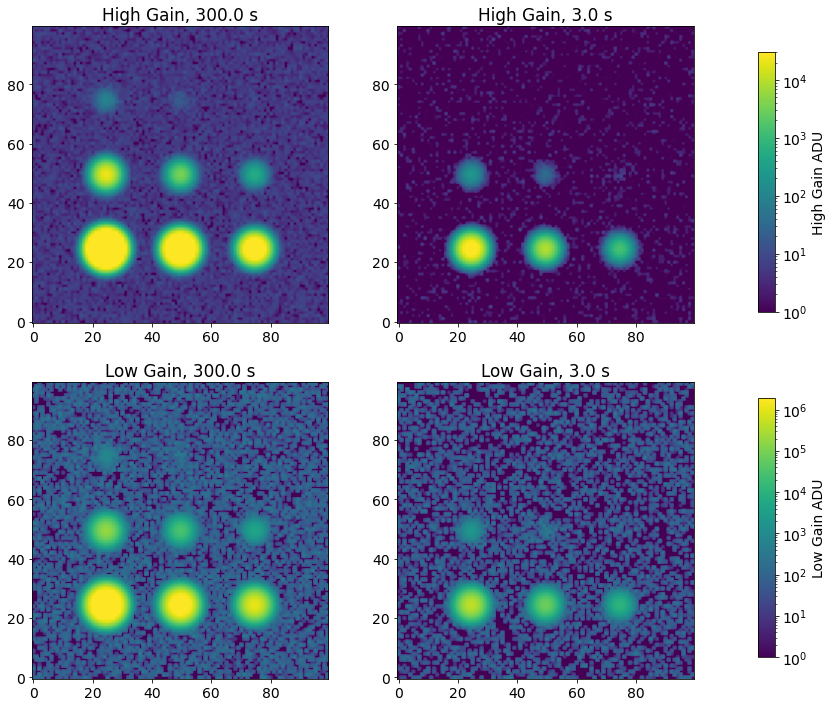

In [4]:
# Create two 2D images
im_frame_size = 100
exp_times = [300,3] * u.s
gain_modes = ['high','low']

# 2 exposures, high/low, long/short
image1 = create_image(im_frame_size, exp_times[0], sources=sources, band=b, gain_mode=gain_modes[0])
image2 = create_image(im_frame_size, exp_times[0], sources=sources, band=b, gain_mode=gain_modes[1])
image3 = create_image(im_frame_size, exp_times[1], sources=sources, band=b, gain_mode=gain_modes[0])
image4 = create_image(im_frame_size, exp_times[1], sources=sources, band=b, gain_mode=gain_modes[1])

im1,im2,im3,im4 = image1.value, image2.value, image3.value, image4.value
im1[im1 == 0], im2[im2 == 0], im3[im3 == 0], im4[im4 == 0] = 0.1, 0.1, 0.1, 0.1

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[12,12])
highax = axes[0,0].imshow(im1, origin='lower', norm=LogNorm(vmin=1, vmax=np.max(im1)))
lowax = axes[1,0].imshow(im2, origin='lower', norm=LogNorm(vmin=1, vmax=np.max(im2)))
axes[0,1].imshow(im3, origin='lower', norm=LogNorm(vmin=1, vmax=np.max(im1)))
axes[1,1].imshow(im4, origin='lower', norm=LogNorm(vmin=1, vmax=np.max(im2)))

axes[0,0].set_title('High Gain, {}'.format(exp_times[0]))
axes[1,0].set_title('Low Gain, {}'.format(exp_times[0]))
axes[0,1].set_title('High Gain, {}'.format(exp_times[1]))
axes[1,1].set_title('Low Gain, {}'.format(exp_times[1]))

fig.subplots_adjust(right=0.9)
cbar_high = fig.add_axes([0.97, 0.55, 0.02, 0.3])
fig.colorbar(highax, cax=cbar_high, label='High Gain ADU')
cbar_low = fig.add_axes([0.97, 0.15, 0.02, 0.3])
fig.colorbar(lowax, cax=cbar_low, label='Low Gain ADU')

plt.show()

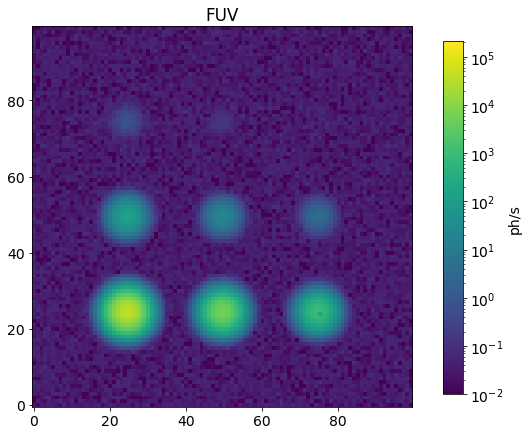

In [149]:
# Apply algorithm
gain = {'high': 1.2 * u.adu / u.electron, 'low': 10.1 * u.adu / u.electron}
read_noise = {'high': 2 * u.electron, 'low': 10 * u.electron}
well_depth = {'high': 25000 * u.electron, 'low': 190000 * u.electron}
qe = 0.4 * u.electron / u.ph

# Logic process: 
# Start with long exposure, high mode. If saturated, go to long exposure, low mode. Then short/high, short/low.
final_image = -np.ones((im_frame_size,im_frame_size)) * u.ph/u.s
fuv_ims = []
for e in exp_times:
    for g in gain_modes:
        im = create_image(im_frame_size, e, sources=sources, band=b, gain_mode=g)
        fuv_ims.append(im)
        
        # Define saturated as well_depth - 3*read_noise
        sat = (well_depth[g] - 3*read_noise[g]) * gain[g]
        not_sat = (final_image.value == -1) & (im < sat)
        
        # Update final_image with value selected from correct frame, converted back to ph/s
        final_image[not_sat] = im[not_sat] / gain[g] / qe / e

final_image[final_image.value <= 0] = 0.001 * final_image.unit

# Display final image (should be no saturated pixels)
fig, axes = plt.subplots(figsize=[7,7])
plt.title('FUV')
f = axes.imshow(final_image.value, origin='lower', norm=LogNorm(vmin=0.01, vmax=np.max(src_cr.value)/5))
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.95, 0.15, 0.04, 0.7])
fig.colorbar(f, cax=cbar, label='ph/s')
plt.show()


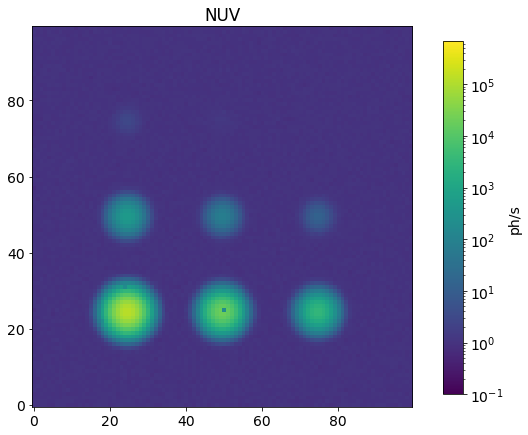

In [45]:
# Once more for NUV
final_image_nuv = -np.ones((im_frame_size,im_frame_size)) * u.ph/u.s
nuv_ims = []
for e in exp_times:
    for g in gain_modes:
        im = create_image(im_frame_size, e, sources=sources_nuv, band='nuv', gain_mode=g)
        nuv_ims.append(im)
        
        # Define saturated as well_depth - 3*read_noise
        sat = (well_depth[g] - 3*read_noise[g]) * gain[g]
        not_sat = (final_image_nuv.value == -1) & (im < sat)
        
        # Update final_image with value selected from correct frame, converted back to ph/s
        final_image_nuv[not_sat] = im[not_sat] / gain[g] / qe / e

final_image_nuv[final_image_nuv.value <= 0] = 0.001 * final_image_nuv.unit

# Display final image (should be no saturated pixels)
fig, axes = plt.subplots(figsize=[7,7])
plt.title('NUV')
f = axes.imshow(final_image_nuv.value, origin='lower', norm=LogNorm(vmin=0.1, vmax=np.max(src_cr_nuv.value)/5))
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.95, 0.15, 0.04, 0.7])
fig.colorbar(f, cax=cbar, label='ph/s')
plt.show()

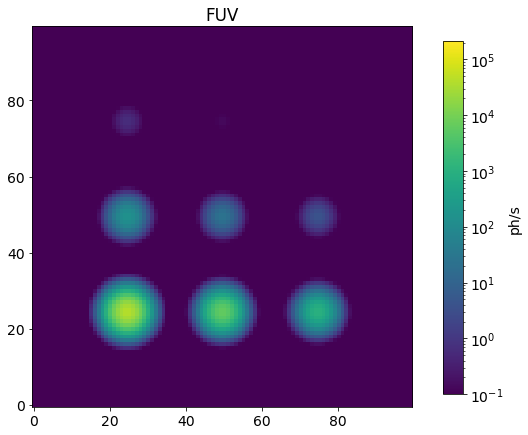

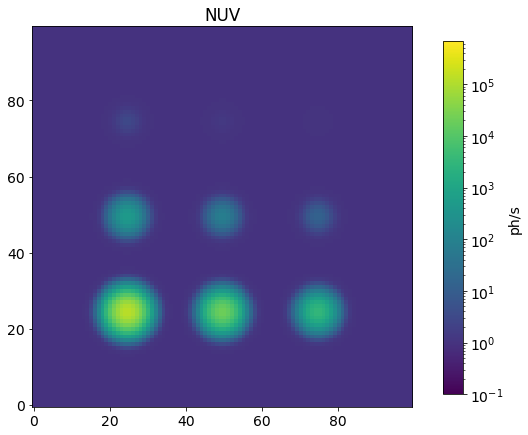

In [89]:
# Create the idealised count rate images for comparison
# Borrow code from the function for this
psf_fwhm = 2 * u.arcsec
pixel_size = 1 * u.arcsec

oversample = 6
src_frame_size = 25 # In pixels
pixel_size_init = pixel_size / oversample
src_frame_size_init = src_frame_size * oversample
im_frame_size_init = im_frame_size * oversample

# Create empty oversampled image
im_array = np.zeros([im_frame_size_init,im_frame_size_init]) * u.ph / u.s
im_array_nuv = np.zeros([im_frame_size_init,im_frame_size_init]) * u.ph / u.s

# Create PSF kernel
psf_kernel = Gaussian2DKernel(psf_fwhm / pixel_size_init,
                              x_size=src_frame_size_init, y_size=src_frame_size_init)

# Add sources - FUV
source_inv = np.array([sources['y_pos'],sources['x_pos']]) # Create array of all ys and all xs
source_pix = (source_inv.transpose() * np.array(im_array.shape)).transpose().astype(int)
im_array[tuple(source_pix)] += sources['src_cr']
im_psf = convolve_fft(im_array.value, psf_kernel) * im_array.unit
shape = (im_frame_size, oversample, im_frame_size, oversample)
im_binned = im_psf.reshape(shape).sum(-1).sum(1)

# Add sources - NUV
source_inv_nuv = np.array([sources_nuv['y_pos'],sources_nuv['x_pos']]) # Create array of all ys and all xs
source_pix_nuv = (source_inv_nuv.transpose() * np.array(im_array_nuv.shape)).transpose().astype(int)
im_array_nuv[tuple(source_pix_nuv)] += sources_nuv['src_cr']
im_psf_nuv = convolve_fft(im_array_nuv.value, psf_kernel) * im_array_nuv.unit
shape = (im_frame_size, oversample, im_frame_size, oversample)
im_binned_nuv = im_psf_nuv.reshape(shape).sum(-1).sum(1)

# Add sky background and dark current
im_binned = im_binned + 0.015 * u.ph / u.s + 0.01 * u.electron / u.s / qe
im_binned_nuv = im_binned_nuv + 1.0 * u.ph / u.s + 0.01 * u.electron / u.s / qe

# Pure count rate images
fig, axes = plt.subplots(figsize=[7,7])
plt.title('FUV')
f = axes.imshow(im_binned.value, origin='lower', norm=LogNorm(vmin=0.1, vmax=np.max(src_cr.value)/5))
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.95, 0.15, 0.04, 0.7])
fig.colorbar(f, cax=cbar, label='ph/s')
plt.show()

fig, axes = plt.subplots(figsize=[7,7])
plt.title('NUV')
f = axes.imshow(im_binned_nuv.value, origin='lower', norm=LogNorm(vmin=0.1, vmax=np.max(src_cr_nuv.value)/5))
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.95, 0.15, 0.04, 0.7])
fig.colorbar(f, cax=cbar, label='ph/s')
plt.show()

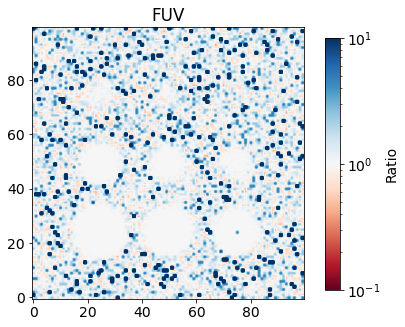

(24, 75)


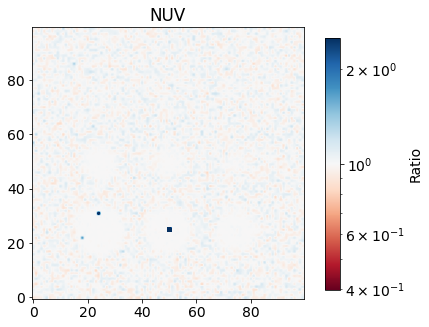

(25, 50)


In [150]:
# Plot difference between result image and perfect input
fig, axes = plt.subplots(figsize=[5,5])
plt.title('FUV')
f = axes.imshow(im_binned.value / final_image.value, origin='lower', cmap='RdBu', norm=LogNorm(vmin=0.1, vmax=10))
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.95, 0.15, 0.04, 0.7])
fig.colorbar(f, cax=cbar, label='Ratio')
plt.show()

a = np.abs(im_binned.value - final_image.value)
fuv_bad_index = np.unravel_index(np.argmax(a, axis=None), a.shape)
print(fuv_bad_index)

fig, axes = plt.subplots(figsize=[5,5])
plt.title('NUV')
f = axes.imshow(im_binned_nuv.value / final_image_nuv.value, origin='lower', cmap='RdBu', norm=LogNorm(vmin=10**-0.4, vmax=10**0.4))
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.95, 0.15, 0.04, 0.7])
fig.colorbar(f, cax=cbar, label='Ratio')
plt.show()

a = np.abs(im_binned_nuv.value - final_image_nuv.value)
nuv_bad_index = np.unravel_index(np.argmax(a, axis=None), a.shape)
print(nuv_bad_index)

29992.8 adu 1918697.0 adu
29991.6 adu 1919101.0 adu 2247.6 adu 19412.2 adu
208.275 ph / s 24.745544554455442 ph / s 20827.5 ph / s 2474.554455445544 ph / s
208.275 ph / s


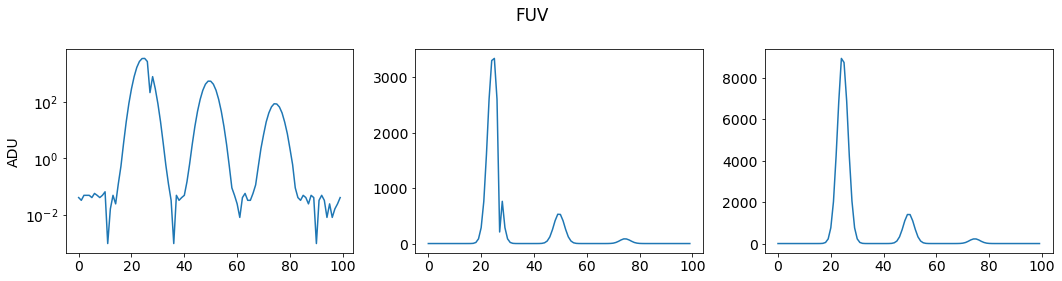

In [119]:
# Define saturated as well_depth - 3*read_noise
sat_high = (well_depth['high'] - 3*read_noise['high']) * gain['high']
sat_low = (well_depth['low'] - 3*read_noise['low']) * gain['low']
print(sat_high,sat_low)

# Find out what's going on with the bad pixels
print(fuv_ims[0][fuv_bad_index],fuv_ims[1][fuv_bad_index],fuv_ims[2][fuv_bad_index],fuv_ims[3][fuv_bad_index])

# Conversion to ph/s
print(fuv_ims[0][fuv_bad_index] / gain['high'] / qe / exp_times[0],
     fuv_ims[0][fuv_bad_index] / gain['low'] / qe / exp_times[0],
     fuv_ims[0][fuv_bad_index] / gain['high'] / qe / exp_times[1],
     fuv_ims[0][fuv_bad_index] / gain['low'] / qe / exp_times[1])

print(final_image[fuv_bad_index])

# Plot PSF shapes to check for discontinuity
plt.figure(figsize=[15,4])
plt.suptitle('FUV')
plt.subplot(131)
plt.semilogy()
plt.plot(np.arange(len(final_image[29,:])),final_image[29,:])
plt.ylabel('ADU')
plt.subplot(132)
plt.plot(np.arange(len(final_image[29,:])),final_image[29,:])
plt.subplot(133)
plt.plot(np.arange(len(final_image[28,:])),final_image[28,:])
plt.tight_layout()
plt.show()

# In conclusion, these pixels are when the read noise sends the pixel under the value at which we define saturation

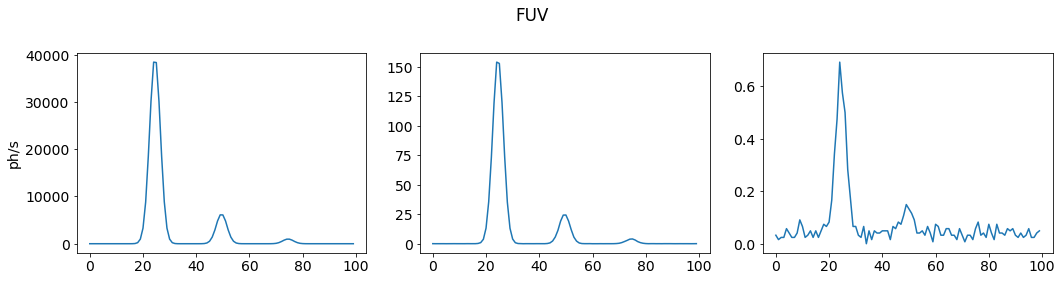

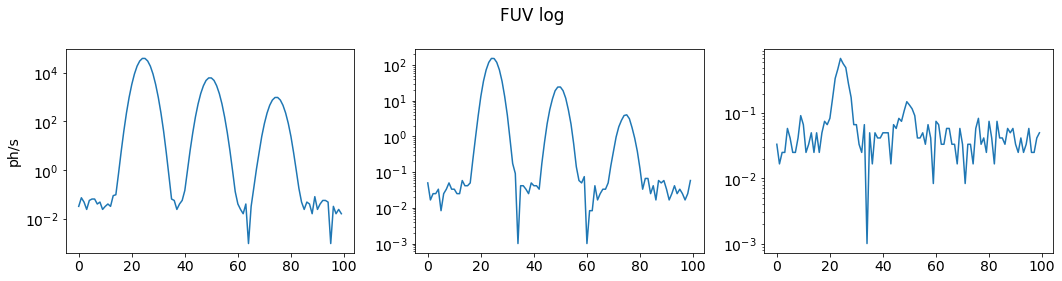

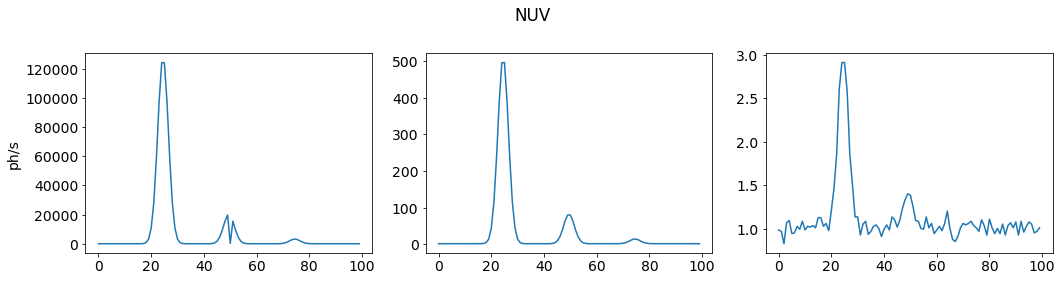

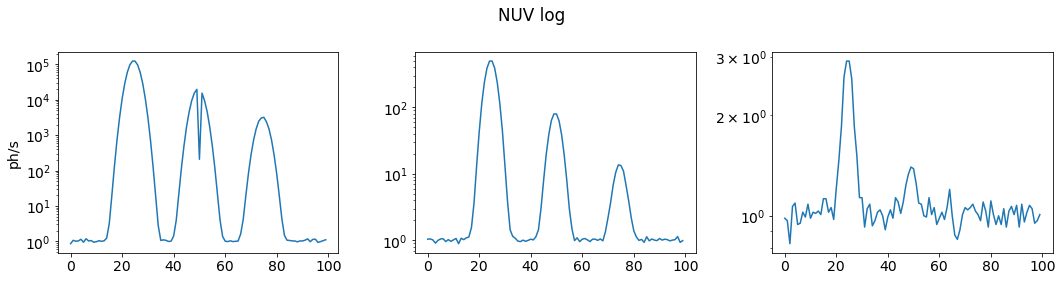

In [151]:
# Plot PSF shapes to check for discontinuity
plt.figure(figsize=[15,4])
plt.suptitle('FUV')
plt.subplot(131)
plt.plot(np.arange(len(final_image[25,:])),final_image[25,:])
plt.ylabel('ph/s')
plt.subplot(132)
plt.plot(np.arange(len(final_image[50,:])),final_image[50,:])
plt.subplot(133)
plt.plot(np.arange(len(final_image[75,:])),final_image[75,:])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,4])
plt.suptitle('FUV log')
plt.subplot(131)
plt.semilogy()
plt.plot(np.arange(len(final_image[25,:])),final_image[25,:])
plt.ylabel('ph/s')
plt.subplot(132)
plt.semilogy()
plt.plot(np.arange(len(final_image[50,:])),final_image[50,:])
plt.subplot(133)
plt.semilogy()
plt.plot(np.arange(len(final_image[75,:])),final_image[75,:])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,4])
plt.suptitle('NUV')
plt.subplot(131)
plt.plot(np.arange(len(final_image_nuv[25,:])),final_image_nuv[25,:])
plt.ylabel('ph/s')
plt.subplot(132)
plt.plot(np.arange(len(final_image_nuv[50,:])),final_image_nuv[50,:])
plt.subplot(133)
plt.plot(np.arange(len(final_image_nuv[75,:])),final_image_nuv[75,:])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,4])
plt.suptitle('NUV log')
plt.subplot(131)
plt.semilogy()
plt.plot(np.arange(len(final_image_nuv[25,:])),final_image_nuv[25,:])
plt.ylabel('ph/s')
plt.subplot(132)
plt.semilogy()
plt.plot(np.arange(len(final_image_nuv[50,:])),final_image_nuv[50,:])
plt.subplot(133)
plt.semilogy()
plt.plot(np.arange(len(final_image_nuv[75,:])),final_image_nuv[75,:])
plt.tight_layout()
plt.show()

In [152]:
# Check flux using aperture photometry (and PSF-fitting photometry?)

# Generate apertures from sources
positions = [(25,25),(50,25),(75,25),(25,50),(50,50),(75,50),(25,75),(50,75),(75,75)]
apertures = CircularAperture(positions, r=12)

# Generate backgrounds from the edges
bg_apertures = RectangularAperture([(6,6),(50,6),(94,6),(6,50),(65,65),(94,50),(6,94),(50,94),(94,94)], w=8, h=8)
bg_masks = bg_apertures.to_mask(method='center')

# Get backgrounds in bg regions
bg_median = []
for mask in bg_masks:
    bg_data = mask.multiply(final_image)
    bg_data_1d = bg_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(bg_data_1d)
    bg_median.append(median_sigclip.value)
bg_median = np.array(bg_median) * final_image.unit

error = calc_total_error(final_image.value, 2 / 300, 300) * final_image.unit

# Perform aperture photometry
result = aperture_photometry(final_image, apertures, error=error)
result['bg_median'] = bg_median
result['aper_bg'] = bg_median * apertures.area
result['aper_sum_bgsub'] = result['aperture_sum'] - result['aper_bg']

for col in result.colnames:
    result[col].info.format = '%.8g'

result.pprint_all()

 id xcenter ycenter aperture_sum aperture_sum_err  bg_median   aper_bg  aper_sum_bgsub
      pix     pix      ph / s         ph / s         ph / s     ph / s      ph / s    
--- ------- ------- ------------ ---------------- ----------- --------- --------------
  1      25      25      1047544        59.091738 0.041666667 18.849556      1047525.2
  2      50      25    166196.74        23.537401 0.033333333 15.079645      166181.66
  3      75      25    25560.483        9.2315609 0.033333333 15.079645      25545.403
  4      25      50    4191.5827        3.7405947 0.033333333 15.079645      4176.5031
  5      50      50    677.59069        1.5095502 0.041666667 18.849556      658.74113
  6      75      50    121.03069       0.65080092 0.033333333 15.079645      105.95105
  7      25      75    33.189355       0.36157624 0.033333333 15.079645       18.10971
  8      50      75    19.379263       0.29103907 0.033333333 15.079645      4.2996187
  9      75      75    16.414906        0.2

In [106]:
# Get backgrounds in annuli
bg_median_nuv = []
for mask in bg_masks:
    bg_data_nuv = mask.multiply(final_image_nuv)
    bg_data_1d_nuv = bg_data_nuv[mask.data > 0]
    _, median_sigclip_nuv, _ = sigma_clipped_stats(bg_data_1d_nuv)
    bg_median_nuv.append(median_sigclip_nuv.value)
bg_median_nuv = np.array(bg_median_nuv) * final_image_nuv.unit

error_nuv = calc_total_error(final_image_nuv.value, 2 / 300, 300) * final_image_nuv.unit

# Perform aperture photometry
result_nuv = aperture_photometry(final_image_nuv, apertures, error=error_nuv)
result_nuv['bg_median'] = bg_median_nuv
result_nuv['aper_bg'] = bg_median_nuv * apertures.area
result_nuv['aper_sum_bgsub'] = result_nuv['aperture_sum'] - result_nuv['aper_bg']

for col in result.colnames:
    result_nuv[col].info.format = '%.8g'

result_nuv.pprint_all()

 id xcenter ycenter aperture_sum aperture_sum_err bg_median  aper_bg  aper_sum_bgsub
      pix     pix      ph / s         ph / s        ph / s    ph / s      ph / s    
--- ------- ------- ------------ ---------------- --------- --------- --------------
  1      25      25      3387407        106.26089 1.0166667 459.92916      3386947.1
  2      50      25    518130.33        41.558648 1.0333333 467.46899      517662.86
  3      75      25    85352.031        16.867924 1.0166667 459.92916      84892.102
  4      25      50    13943.687         6.819022 1.0083333 456.15925      13487.527
  5      50      50    2600.2789        2.9474909 1.0166667 459.92916      2140.3497
  6      75      50    801.20149        1.6403591 1.0166667 459.92916      341.27233
  7      25      75    514.85726        1.3176863 1.0166667 459.92916        54.9281
  8      50      75    468.71222        1.2579667 1.0083333 456.15925      12.552965
  9      75      75    463.23644        1.2506909 1.0166667 459.9

In [153]:
# Also get: low-gain 3s photometry for first two, high-gain 3s for the 3rd, 
# low-gain 300s for the 4th, high-gain 300s for the rest

# Get backgrounds in bg regions
bg_median_orig = []
for i, mask in enumerate(bg_masks):
    if i <= 1:
        bg_data = mask.multiply(fuv_ims[3])
        bg_data_cr = bg_data / gain['low'] / qe / exp_times[1]
    elif i == 2:
        bg_data = mask.multiply(fuv_ims[2])
        bg_data_cr = bg_data / gain['high'] / qe / exp_times[1]
    elif i == 3:
        bg_data = mask.multiply(fuv_ims[1])
        bg_data_cr = bg_data / gain['low'] / qe / exp_times[0]
    else:
        bg_data = mask.multiply(fuv_ims[0])
        bg_data_cr = bg_data / gain['high'] / qe / exp_times[0]
        
    bg_data_1d = bg_data_cr[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(bg_data_1d)
    bg_median_orig.append(median_sigclip.value)
bg_median_orig = np.array(bg_median_orig) * bg_data_cr.unit

# Perform aperture photometry
results_orig = []
for i in range(4):
    if i <= 1:
        exp = exp_times[0]
    else:
        exp = exp_times[1]
        
    if (i == 0) | (i == 2):
        g = 'high'
    else:
        g = 'low'
        
    # Convert to ph/s
    fuv_im_cr = fuv_ims[i] / gain[g] / qe / exp
    
    error = calc_total_error(fuv_im_cr.value, 2 / exp.value, exp.value) * fuv_im_cr.unit
    result_orig = aperture_photometry(fuv_im_cr, apertures, error=error)

    result_orig['bg_median'] = bg_median_orig
    result_orig['aper_bg'] = bg_median_orig * apertures.area
    result_orig['aper_sum_bgsub'] = result_orig['aperture_sum'] - result_orig['aper_bg']

    for col in result_orig.colnames:
        result_orig[col].info.format = '%.8g'
        
    results_orig.append(result_orig)

result_orig = vstack([results_orig[3][0:2],results_orig[2][2:3],results_orig[1][3:4],results_orig[0][4:]])    
result_orig.pprint_all()

 id xcenter ycenter aperture_sum aperture_sum_err  bg_median   aper_bg  aper_sum_bgsub
      pix     pix      ph / s         ph / s         ph / s     ph / s      ph / s    
--- ------- ------- ------------ ---------------- ----------- --------- --------------
  1      25      25    1048286.8        591.29518           0         0      1048286.8
  2      50      25    166657.02        236.12158           0         0      166657.02
  3      75      25    26481.714        95.017366           0         0      26481.714
  4      25      50     4184.037        3.7372311       0.025 11.309734      4172.7273
  5      50      50      677.579        1.5095373 0.041666667 18.849556      658.72945
  6      75      50    121.02218       0.65077912 0.033333333 15.079645      105.94254
  7      25      75     33.17365       0.36150384 0.033333333 15.079645      18.094005
  8      50      75    19.367983       0.29097446 0.033333333 15.079645      4.2883387
  9      75      75    16.399463       0.27

In [147]:
# Once more for the NUV

# Get backgrounds in bg regions
bg_median_orig_nuv = []
for i, mask in enumerate(bg_masks):
    if i <= 1:
        bg_data = mask.multiply(nuv_ims[3])
        bg_data_cr = bg_data / gain['low'] / qe / exp_times[1]
    elif i == 2:
        bg_data = mask.multiply(nuv_ims[2])
        bg_data_cr = bg_data / gain['high'] / qe / exp_times[1]
    elif i == 3:
        bg_data = mask.multiply(nuv_ims[1])
        bg_data_cr = bg_data / gain['low'] / qe / exp_times[0]
    else:
        bg_data = mask.multiply(nuv_ims[0])
        bg_data_cr = bg_data / gain['high'] / qe / exp_times[0]
        
    bg_data_1d = bg_data_cr[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(bg_data_1d)
    bg_median_orig_nuv.append(median_sigclip.value)
bg_median_orig_nuv = np.array(bg_median_orig_nuv) * bg_data_cr.unit

# Perform aperture photometry
results_orig_nuv = []
for i in range(4):
    if i <= 1:
        exp = exp_times[0]
    else:
        exp = exp_times[1]
        
    if (i == 0) | (i == 2):
        g = 'high'
    else:
        g = 'low'
        
    # Convert to ph/s
    nuv_im_cr = nuv_ims[i] / gain[g] / qe / exp
    
    error = calc_total_error(nuv_im_cr.value, 2 / exp.value, exp.value) * nuv_im_cr.unit
    result_orig_nuv = aperture_photometry(nuv_im_cr, apertures, error=error)

    result_orig_nuv['bg_median'] = bg_median_orig_nuv
    result_orig_nuv['aper_bg'] = bg_median_orig_nuv * apertures.area
    result_orig_nuv['aper_sum_bgsub'] = result_orig_nuv['aperture_sum'] - result_orig_nuv['aper_bg']

    for col in result_orig_nuv.colnames:
        result_orig_nuv[col].info.format = '%.8g'
        
    results_orig_nuv.append(result_orig_nuv)

result_orig_nuv = vstack([results_orig_nuv[3][0:2],results_orig_nuv[2][2:3],results_orig_nuv[1][3:4],results_orig_nuv[0][4:]])    
result_orig_nuv.pprint_all()

 id xcenter ycenter aperture_sum aperture_sum_err bg_median   aper_bg  aper_sum_bgsub
      pix     pix      ph / s         ph / s        ph / s     ph / s      ph / s    
--- ------- ------- ------------ ---------------- ---------- --------- --------------
  1      25      25    3389322.4        1063.0029          0         0      3389322.4
  2      50      25    537274.35        423.42946          0         0      537274.35
  3      75      25    85261.717         169.1793 0.83333333 376.99112      84884.726
  4      25      50    13952.216        6.8211065  1.0583333 478.77872      13473.438
  5      50      50    2600.2789        2.9474909  1.0166667 459.92916      2140.3497
  6      75      50    801.20149        1.6403591  1.0166667 459.92916      341.27233
  7      25      75    514.85726        1.3176863  1.0166667 459.92916        54.9281
  8      50      75    468.71222        1.2579667  1.0083333 456.15925      12.552965
  9      75      75    463.23644        1.2506909  1.0

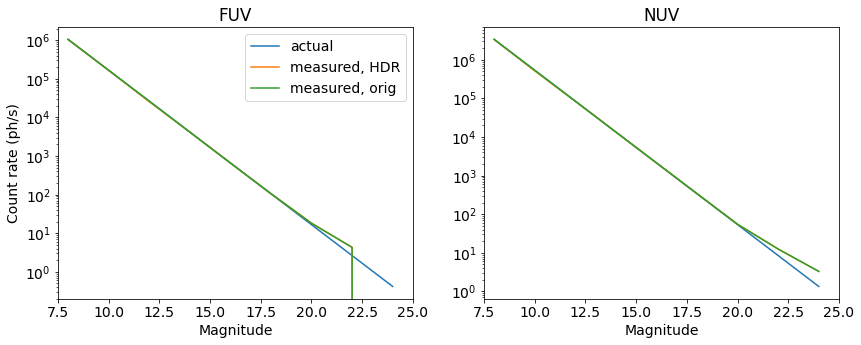

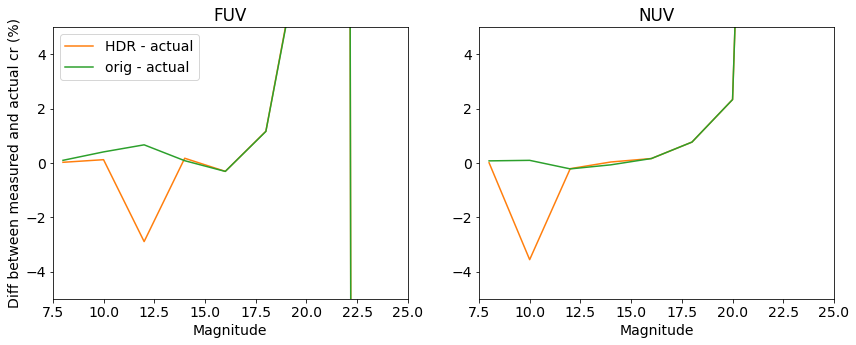

In [162]:
# Plot ideal and measured count rates against each other
plt.figure(figsize=[14,5])
plt.subplot(121)
plt.title('FUV')
plt.semilogy()
plt.plot(mags,src_cr,label='actual')
plt.plot(mags,result['aper_sum_bgsub'],label='measured, HDR')
plt.plot(mags,result_orig['aper_sum_bgsub'],label='measured, orig')
plt.xlabel('Magnitude')
plt.ylabel('Count rate (ph/s)')
plt.xlim([7.5,25])
plt.legend()
plt.subplot(122)
plt.title('NUV')
plt.semilogy()
plt.plot(mags,src_cr_nuv)
plt.plot(mags,result_nuv['aper_sum_bgsub'])
plt.plot(mags,result_orig_nuv['aper_sum_bgsub'])
plt.xlabel('Magnitude')
plt.xlim([7.5,25])
plt.show()

plt.figure(figsize=[14,5])
plt.subplot(121)
plt.title('FUV')
plt.plot([0,0],[0,0])
plt.plot(mags,(result['aper_sum_bgsub'] - src_cr) / src_cr * 100,label='HDR - actual')
plt.plot(mags,(result_orig['aper_sum_bgsub'] - src_cr) / src_cr * 100,label='orig - actual')
plt.xlabel('Magnitude')
plt.ylabel('Diff between measured and actual cr (%)')
plt.xlim([7.5,25])
plt.ylim([-5,5])
plt.legend()
plt.subplot(122)
plt.title('NUV')
plt.plot([0,0],[0,0])
plt.plot(mags,(result_nuv['aper_sum_bgsub'] - src_cr_nuv) / src_cr_nuv * 100)
plt.plot(mags,(result_orig_nuv['aper_sum_bgsub'] - src_cr_nuv) / src_cr_nuv * 100)
plt.xlabel('Magnitude')
plt.xlim([7.5,25])
plt.ylim([-5,5])
plt.show()

In [161]:
# Find ideal saturation definition by looking at saturated image from test detector
saturated_low_file = ''
saturated_high_file = '../data/012121/cmostjpl003_20210121234130.fits'

all_files = scan_headers('../data/020321')
all_files.sort('DATE')
all_files.pprint_all()

                   FILEPATH                    READOUTM            DATE            EXPTIME LED   TEMP  CAMERAID      DETID      GAIN
---------------------------------------------- -------- -------------------------- ------- --- ------- -------- --------------- ----
../data/020321/cmostjpl001_20210203182644.fits  DEFAULT 2021-02-03 18:26:49.293675  1000.0 1.6   140.0 cmostjpl EuropaBSI-1-7-3 high
../data/020321/cmostjpl001_20210203182705.fits  DEFAULT 2021-02-03 18:27:12.254249  1975.0 1.6   140.0 cmostjpl EuropaBSI-1-7-3 high
../data/020321/cmostjpl001_20210203185558.fits  DEFAULT 2021-02-03 18:56:09.799281  3902.0 1.6   140.0 cmostjpl EuropaBSI-1-7-3 high
../data/020321/cmostjpl001_20210203185638.fits  DEFAULT 2021-02-03 18:56:56.544894  6501.0 1.6 140.001 cmostjpl EuropaBSI-1-7-3 high
../data/020321/cmostjpl001_20210203192604.fits  DEFAULT 2021-02-03 19:26:33.605327 10833.0 1.6   140.0 cmostjpl EuropaBSI-1-7-3 high
../data/020321/cmostjpl001_20210203193334.fits  DEFAULT 2021-02-03 19